In [1]:
import os
import glob
import json
import h5py
import copy

import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns
import cPickle as pkl
import matplotlib.gridspec as gridspec

from pipeline.python.classifications import utils as util
from pipeline.python.classifications import test_responsivity as resp
from pipeline.python.utils import label_figure, natural_keys, convert_range

from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from matplotlib.patches import Ellipse, Rectangle

from shapely.geometry.point import Point
from shapely import affinity
from matplotlib.patches import Polygon

from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator

import matplotlib_venn as mpvenn
import itertools


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/utils.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()


In [2]:
%matplotlib notebook

In [3]:
rootdir = '/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'

In [4]:
all_rats = [os.path.split(os.path.split(f)[0])[-1] for f in glob.glob(os.path.join(rootdir, 'JC*', 'sessionmeta.json'))]
all_rats

['JC084',
 'JC091',
 'JC085',
 'JC090',
 'JC099',
 'JC097',
 'JC076',
 'JC078',
 'JC080',
 'JC083']

# Get list of all datasets

In [5]:
visual_areas = ['V1', 'Lm', 'Li']
state = 'awake'
traceid = 'traces001'
trace_type = 'corrected'
#sessiondatapaths = dict((visual_area, {}) for visual_area in visual_areas)
sessiondata = []
blacklist = ['20190514', '20190530']

dcounter = 0
for animalid in all_rats:

        
    # Get metadata for this rat's sessions:
    with open(os.path.join(rootdir, animalid, 'sessionmeta.json'), 'r') as f:
        sessionmeta = json.load(f)
    
    # Get session data paths, if exist:
    for visual_area in visual_areas:
        curr_session_list = [str(k) for k, v in sessionmeta.items()\
                             if v['state'] == state and v['visual_area'] == visual_area]
        
        if len(curr_session_list) > 0:
            #if animalid not in sessiondatapaths[visual_area].keys():
            #    sessiondatapaths[visual_area][animalid] = {}
            

            for s in curr_session_list:

                    
                session_str = s.split('_')[0]
                fov_str = s.split('_')[-1]
                if session_str in blacklist:
                    continue
                    
                found_fovs = glob.glob(os.path.join(rootdir, animalid, session_str, '%s*' % fov_str))
                for fov_dir in found_fovs:
                    #fov_dir = glob.glob(os.path.join(rootdir, animalid, session_str, '%s*' % fov_str))[0]
                    session_fpath = os.path.join(fov_dir, 'summaries', 'sessiondata.pkl')    

                    if os.path.exists(session_fpath):
                        with open(session_fpath, 'rb') as f:
                            S = pkl.load(f)
                    else:
                        print("Creating new session object...") #% (animalid, session_name))
                        S = util.Session(animalid, session_str, '%s_%s' % (fov_str, fov_type), 
                                         visual_area=visual_area, state=state,
                                         rootdir=rootdir)
                        with open(session_fpath, 'wb') as f:
                            pkl.dump(S, f, protocol=pkl.HIGHEST_PROTOCOL)
                        print("... created session object!")

                    experiment_list = S.get_experiment_list(traceid=traceid, trace_type=trace_type)

                    #sessiondatapaths[visual_area][animalid].update({s: experiment_list})

                    for e in experiment_list:
                        if 'dyn' in e:
                            continue
                        sessiondata.append(pd.DataFrame({'visual_area': visual_area, 
                                                           'animalid': animalid, 
                                                           'experiment': e,
                                                          'session': session_str,
                                                        'fov': '%s_%s' % (fov_str, fov_type)}, index=[dcounter]) )
                        dcounter += 1

        else:
            print("[%s] %s - skipping" % (animalid, visual_area))


[JC084] Li - skipping
[JC091] V1 - skipping
[JC085] Lm - skipping
[JC085] Li - skipping
[JC090] V1 - skipping
[JC090] Lm - skipping
[JC099] V1 - skipping
[JC099] Lm - skipping
[JC097] Lm - skipping
[JC097] Li - skipping
[JC078] V1 - skipping
[JC078] Li - skipping
[JC080] V1 - skipping
[JC083] Li - skipping


In [6]:
curr_session_list

[]

In [7]:
sessiondata = pd.concat(sessiondata, axis=0)

In [8]:
sessiondata.describe()

,animalid,experiment,fov,session,visual_area
count,127,127,127,127,127
unique,10,5,2,33,3
top,JC083,retino,FOV1_zoom2p0x,20190602,Lm
freq,21,35,123,9,46


In [9]:
experiment_types = sorted(sessiondata['experiment'].unique(), key=natural_keys)
experiment_ids = dict((exp, i) for i, exp in enumerate(experiment_types))
animal_names = sorted(sessiondata['animalid'].unique(), key=natural_keys)
animal_ids = dict((animal, i) for i, animal in enumerate(animal_names))

sessiondata['exp_no'] = [int(experiment_ids[exp]) for exp in sessiondata['experiment']]
sessiondata['animal_no'] = [int(animal_ids[animal]) for animal in sessiondata['animalid']]

In [10]:
sessiondata.head()

,animalid,experiment,fov,session,visual_area,exp_no,animal_no
0,JC084,rfs,FOV1_zoom2p0x,20190522,V1,3,4
1,JC084,gratings,FOV1_zoom2p0x,20190522,V1,1,4
2,JC084,blobs,FOV1_zoom2p0x,20190522,V1,0,4
3,JC084,retino,FOV1_zoom2p0x,20190522,V1,2,4
4,JC084,rfs,FOV1_zoom2p0x,20190525,Lm,3,4


In [11]:
counts = sessiondata.groupby(['visual_area', 'animalid', 'experiment']).size()

In [12]:
counts.head()

visual_area  animalid  experiment
Li           JC076     blobs         2
                       gratings      1
                       retino        1
             JC080     retino        1
                       rfs10         1
dtype: int64

In [13]:
print visual_area
dset_counts = counts.loc[visual_area][:, 'blobs']
dset_counts.shape
dset_counts

Li


animalid
JC076    2
JC090    1
JC091    4
JC099    3
dtype: int64

In [14]:
n_animals_per = sessiondata.groupby(['visual_area'])['animalid'].unique()
    
group_by_animal = [len(s) for s in n_animals_per] #.reset_index().pivot(columns='animalid', index='visual_area', values=0)
print(group_by_animal)
n_animals_per

[5, 6, 5]


visual_area
Li           [JC091, JC090, JC099, JC076, JC080]
Lm    [JC084, JC091, JC076, JC078, JC080, JC083]
V1           [JC084, JC085, JC097, JC076, JC083]
Name: animalid, dtype: object

In [15]:
#df_plot = sessiondata.groupby(['visual_area', 'experiment']).size().reset_index().pivot(columns='visual_area', index='experiment', values=0)
group_by_area = sessiondata.groupby(['visual_area', 'experiment']).size().reset_index().pivot(columns='experiment', index='visual_area', values=0)
group_by_experiment = sessiondata.groupby(['visual_area', 'experiment']).size().reset_index().pivot(columns='visual_area', index='experiment', values=0)
#group_by_animal = sessiondata.groupby(['visual_area', 'animalid']).unique().reset_index().pivot(columns='animalid', index='visual_area', values=0)

#group_by_animal

In [16]:
sessiondata[sessiondata['animalid']=='JC080']['session'].unique()

array(['20190603', '20190506', '20190602'], dtype=object)

# Create output figure dir:

In [17]:
outputdir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
datasetdir = os.path.join(outputdir, 'dataset_info')
if not os.path.exists(datasetdir):
    os.makedirs(datasetdir)
    

<IPython.core.display.Javascript object>


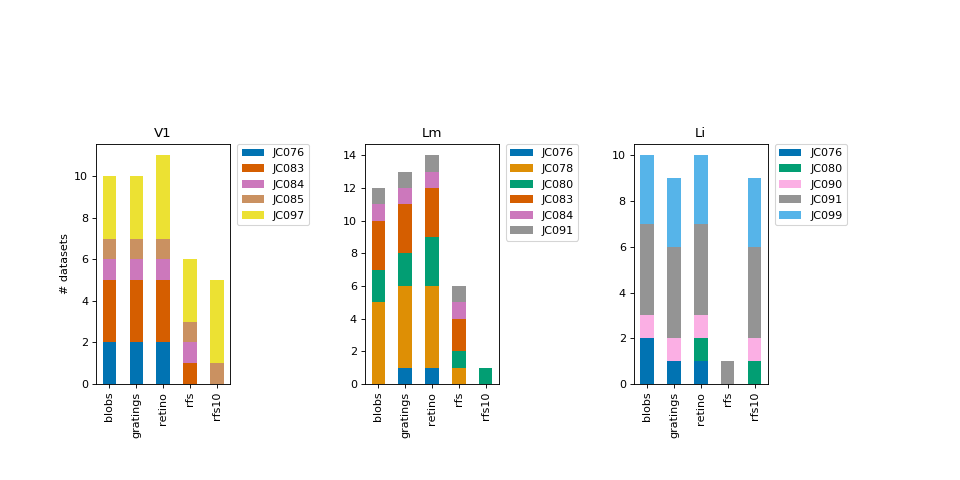

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/pandas/plotting/_core.py:179: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


In [18]:
# Give each animal unique color:
animal_color_list = sns.color_palette('colorblind', len(animal_names))
animal_cdict = dict((animal, animal_color_list[ai]) for ai, animal in enumerate(animal_names))

fig, axes = pl.subplots(1, 3, figsize=(12, 6))

for ai, (ax, visual_area) in enumerate(zip(axes.flat, visual_areas)):
    color_list = [animal_cdict[a] for a in sessiondata[sessiondata['visual_area']==visual_area]['animalid']]
    group_by_animal = sessiondata[sessiondata['visual_area']==visual_area].groupby(['animalid', 'experiment']).size().reset_index().pivot(columns='animalid', index='experiment', values=0)
    color_list = [animal_cdict[a] for a in group_by_animal.columns.tolist()]
    group_by_animal.plot(kind='bar', stacked=True, ax=ax, colors=color_list)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_xlabel('')
    ax.set_title(visual_area)
    if ai == 0:
        ax.set_ylabel('# datasets')
pl.subplots_adjust(wspace=1, top=0.7, bottom = 0.2, left=0.1, right=0.8)

pl.savefig(os.path.join(datasetdir, 'awake_datasets_exp_by_animal.png'))


<IPython.core.display.Javascript object>


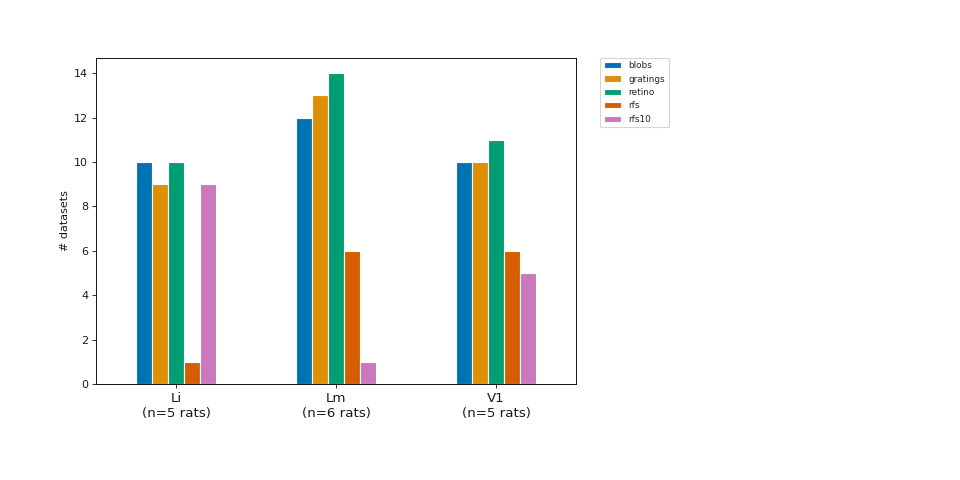

In [19]:
fig, ax = pl.subplots(figsize=(12, 6))
sns.set(style="white")
sns.set_palette('colorblind')
# ax = axes[0]
# ax.bar(range(len(visual_areas)), [len(n) for n in n_animals_per.values])
# ax.set_xticklabels(n_animals_per.index.tolist())

#ax = axes[0]
group_by_area.plot(kind='bar', stacked=False, ax=ax)
ax.set_ylabel('# datasets')
v_area = n_animals_per.index.tolist()
v_nrats = [len(n) for n in n_animals_per.values]
ax.set_xticklabels(['%s\n(n=%i rats)' % (v, n) for v, n in zip(v_area, v_nrats)], rotation=0, fontsize=12)

ax.set_xlabel('')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)

pl.subplots_adjust(wspace=1, bottom=0.2, right=0.6, left=0.1)
ax.set_xlabel('')

pl.savefig(os.path.join(datasetdir, 'awake_datasets_area_by_experiment.png'))


In [20]:
sessions_by_animal = sessiondata.groupby(['animalid', 'session'])['fov'].unique()

In [21]:
sessions_by_animal

animalid  session 
JC076     20190420                   [FOV1_zoom2p0x]
          20190422                   [FOV1_zoom2p0x]
          20190423                   [FOV1_zoom2p0x]
          20190501                   [FOV1_zoom2p0x]
          20190502                   [FOV1_zoom2p0x]
JC078     20190426                   [FOV1_zoom2p0x]
          20190430                   [FOV1_zoom2p0x]
          20190504                   [FOV1_zoom2p0x]
          20190509                   [FOV1_zoom2p0x]
          20190513                   [FOV1_zoom2p0x]
JC080     20190506                   [FOV1_zoom2p0x]
          20190602    [FOV2_zoom2p0x, FOV1_zoom2p0x]
          20190603                   [FOV1_zoom2p0x]
JC083     20190507                   [FOV1_zoom2p0x]
          20190508                   [FOV1_zoom2p0x]
          20190510                   [FOV1_zoom2p0x]
          20190511                   [FOV1_zoom2p0x]
          20190512                   [FOV1_zoom2p0x]
          20190517         

In [22]:
sessions_by_animal['JC080']

session
20190506                   [FOV1_zoom2p0x]
20190602    [FOV2_zoom2p0x, FOV1_zoom2p0x]
20190603                   [FOV1_zoom2p0x]
Name: fov, dtype: object

In [23]:
session_list

NameError: name 'session_list' is not defined

In [34]:
aggregate_session_dir = os.path.join(datasetdir, 'session_stats')
if not os.path.exists(aggregate_session_dir):
    os.makedirs(aggregate_session_dir)

In [42]:
sessions_by_animal

animalid  session 
JC076     20190420                   [FOV1_zoom2p0x]
          20190422                   [FOV1_zoom2p0x]
          20190423                   [FOV1_zoom2p0x]
          20190501                   [FOV1_zoom2p0x]
          20190502                   [FOV1_zoom2p0x]
JC078     20190426                   [FOV1_zoom2p0x]
          20190430                   [FOV1_zoom2p0x]
          20190504                   [FOV1_zoom2p0x]
          20190509                   [FOV1_zoom2p0x]
          20190513                   [FOV1_zoom2p0x]
JC080     20190506                   [FOV1_zoom2p0x]
          20190602    [FOV2_zoom2p0x, FOV1_zoom2p0x]
          20190603                   [FOV1_zoom2p0x]
JC083     20190507                   [FOV1_zoom2p0x]
          20190508                   [FOV1_zoom2p0x]
          20190510                   [FOV1_zoom2p0x]
          20190511                   [FOV1_zoom2p0x]
          20190512                   [FOV1_zoom2p0x]
          20190517         

In [48]:
sessiondata['animalid'].unique()

array(['JC084', 'JC091', 'JC085', 'JC090', 'JC099', 'JC097', 'JC076',
       'JC078', 'JC080', 'JC083'], dtype=object)

In [ ]:
for animalid in sessiondata['animalid'].unique():
    session_list = sessions_by_animal[animalid].index.tolist()
    for session in session_list:
        fovs = sessions_by_animal[animalid][session]

        for fov in fovs:
            stats.visualize_session_stats(animalid, session, fov, create_new=False, altdir=aggregate_session_dir)

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/summaries
creating new session object...
[JC084] 20190522 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
found 4 experiments
Calculating stats
[rfs] Loading roi lists...
('Getting stats:', 'rfs')
('... getting grouped stats  for experiments: ', [])
no exp data saved, loading now...
... Loading data (rfs - traces001 - corrected)
('EXP:', ['rfs'])
-- rfs: got rois
 [JC084 | 20190522 | FOV1_zoom2p0x] creating experiment object - rfs
... getting data paths
... ... combined_rfs_static
... ... renaming experiment to run name: combined_rfs_static
-- rfs: got source
... loading data array (combined_rfs_static - datasets.npz)
... loaded
(246708, 6)
... making equal
loaded
rfs: calculating stats
... [combined_rfs_static] Loading roi stats and cell list...
... loading event data
... loading RF fits: zscore0.00_no_trim
... loaded rf fits
... Found 114 responsive cells.
... loading data array (combined_rf

<IPython.core.display.Javascript object>

--- done! ---
/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/summaries
creating new session object...
[JC084] 20190525 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
found 4 experiments
Calculating stats
[rfs] Loading roi lists...
('Getting stats:', 'rfs')
('... getting grouped stats  for experiments: ', [])
no exp data saved, loading now...
... Loading data (rfs - traces001 - corrected)
('EXP:', ['rfs'])
-- rfs: got rois
 [JC084 | 20190525 | FOV1_zoom2p0x] creating experiment object - rfs
... getting data paths
... ... combined_rfs_static
... ... renaming experiment to run name: combined_rfs_static
-- rfs: got source
... loading data array (combined_rfs_static - datasets.npz)
... loaded
(228018, 6)
... making equal
incorrect reps / condn...
loaded
rfs: calculating stats
... [combined_rfs_static] Loading roi stats and cell list...
... loading event data
... loading RF fits: zscore0.00_no_trim
... loaded rf fits
... Found 43 responsive cel

<IPython.core.display.Javascript object>

--- done! ---
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/summaries
creating new session object...
[JC091] 20190602 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
found 5 experiments
Calculating stats
[rfs] Loading roi lists...
('Getting stats:', 'rfs')
('... getting grouped stats  for experiments: ', [])
no exp data saved, loading now...
... Loading data (rfs - traces001 - corrected)
('EXP:', ['rfs'])
-- rfs: got rois
 [JC091 | 20190602 | FOV1_zoom2p0x] creating experiment object - rfs
... getting data paths
... ... combined_rfs_static
... ... renaming experiment to run name: combined_rfs_static
-- rfs: got source
... loading data array (combined_rfs_static - datasets.npz)
... loaded
(252048, 6)
... making equal
incorrect reps / condn...
ERROR LOADING DATA

loaded
rfs: calculating stats
... [combined_rfs_static] Loading roi stats and cell list...
... loading event data
... loading RF fits: zscore0.00_no_trim
... loaded rf fits
... Fou

In [37]:
reload(stats)

<module 'pipeline.python.classifications.run_experiment_stats' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/run_experiment_stats.pyc'>

In [25]:
from pipeline.python.classifications import run_experiment_stats as stats

In [29]:
for animalid in session_by_animal.index.tolist():
    

Index([u'JC076', u'JC078', u'JC080', u'JC083', u'JC084', u'JC085', u'JC090',
       u'JC091', u'JC097', u'JC099'],
      dtype='object', name=u'animalid')

<IPython.core.display.Javascript object>


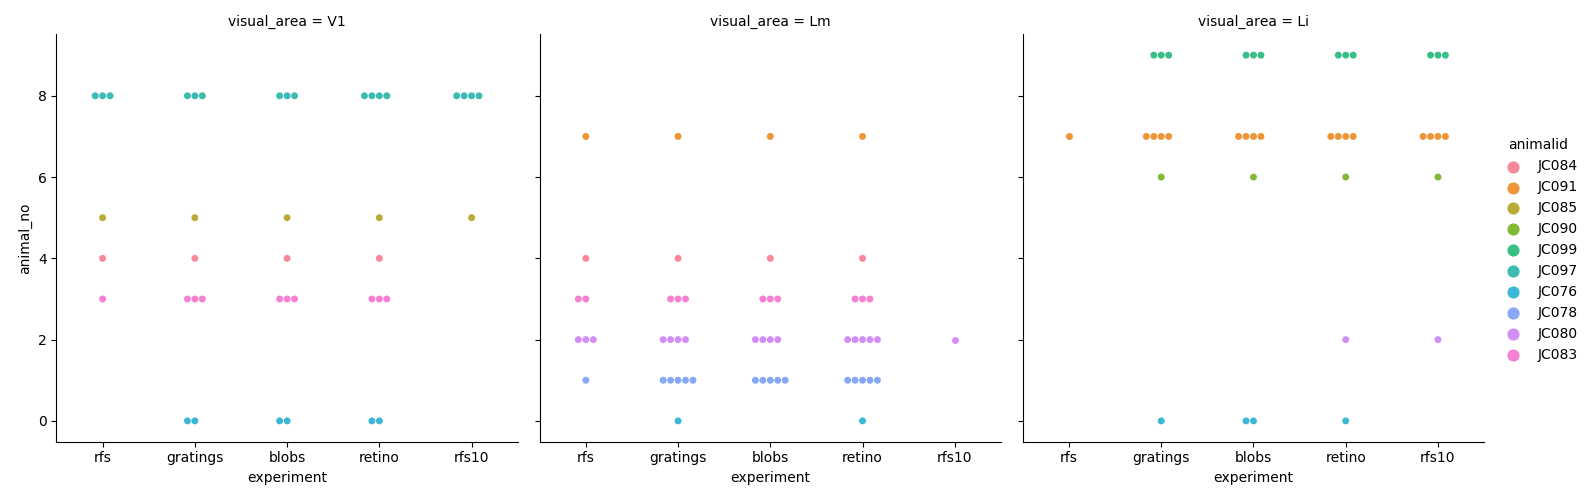

In [69]:
sns.catplot(x='experiment', y='animal_no', col='visual_area', hue='animalid', kind='swarm', data=sessiondata)

In [29]:
sessiondata.dtypes

animalid       object
experiment     object
visual_area    object
exp_no          int64
dtype: object

In [ ]:
rootdir = '/n/coxfs01/2p-data'

animalid = 'JC097'
session = '20190617'
fov = 'FOV1_zoom2p0x'
traceid = 'traces001'


In [ ]:
# Create output_dir

output_dir = os.path.join(rootdir, animalid, session, fov, 'summaries')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print(output_dir)

In [ ]:
session_outfile = os.path.join(output_dir, 'sessiondata.pkl')
create_new = False

if os.path.exists(session_outfile) and create_new is False:
    print("loading session object...")
    with open(session_outfile, 'rb') as f:
        S = pkl.load(f)

else:
    print("creating new session object...")
    S = util.Session(animalid, session, fov, rootdir=rootdir)
    S.load_data(traceid=traceid, trace_type='corrected')
    
    # Save session data object
    with open(session_outfile, 'wb') as f:
        pkl.dump(S, f, protocol=pkl.HIGHEST_PROTOCOL)
    

In [ ]:
responsive_test = 'ROC'

mag_ratio_thr = 0.01
#rf_fit_thr = 0.5
gdfs = {}
for exp_name, exp in S.experiments.items():
    
    print("[%s] Loading roi lists..." % exp_name)
    
    estats = S.get_grouped_stats(exp, responsive_test=responsive_test, responsive_thr=mag_ratio_thr)
    
    gdfs[estats.experiment_id] = estats
    

In [ ]:
all_values = []
for exp_name in exp_colors.keys():
    all_values.extend(gdfs[exp_name].gdf.max()['meanstim'].values)